**Imports and Setup**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

**Dataset Class**

In [32]:
class EyeBoundingBoxDataset(Dataset):
    def __init__(self, subject_id, root_dir, transform=None):
        self.root_dir = root_dir
        self.subject_id = f"S_{subject_id}"
        self.img_dir = os.path.join(root_dir, 'openEDS', 'openEDS', self.subject_id)
        self.bbox_file = os.path.join(root_dir, 'bbox', 'bbox', f"{self.subject_id}.txt")
        self.transform = transform

        with open(self.bbox_file, 'r') as f:
            lines = f.readlines()
            self.bboxes = [list(map(float, line.strip().split())) for line in lines]

    def __len__(self):
        return len(self.bboxes) - 1  # because we use t0 and t1 pairs

    def __getitem__(self, idx):
        img0_path = os.path.join(self.img_dir, f"{idx}.png")
        img1_path = os.path.join(self.img_dir, f"{idx+1}.png")

        img0 = Image.open(img0_path).convert('L')
        img1 = Image.open(img1_path).convert('L')

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        diff = img1 - img0
        input_tensor = torch.cat((img1, diff), dim=0)  # shape: (2, H, W)

        target = torch.tensor(self.bboxes[idx+1], dtype=torch.float32)

        return input_tensor, target

**Model Definition**

In [33]:
class LightweightBBoxCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),  # Correct shape for 64x64 input and 3 maxpool layers
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

**Transform and DataLoader Setup**

In [34]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = EyeBoundingBoxDataset(subject_id=0, root_dir='/Users/omaraguilarjr/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/openEDS2019', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

**Training and Evaluation**

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightweightBBoxCNN().to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1/100 - Train Loss: 300.7130 - Val Loss: 298.2736
Epoch 2/100 - Train Loss: 289.4064 - Val Loss: 265.7716
Epoch 3/100 - Train Loss: 210.3539 - Val Loss: 124.2415
Epoch 4/100 - Train Loss: 112.1256 - Val Loss: 60.2237
Epoch 5/100 - Train Loss: 39.5243 - Val Loss: 45.8184
Epoch 6/100 - Train Loss: 38.8631 - Val Loss: 33.0982
Epoch 7/100 - Train Loss: 27.0084 - Val Loss: 25.4570
Epoch 8/100 - Train Loss: 23.0268 - Val Loss: 22.1969
Epoch 9/100 - Train Loss: 19.6137 - Val Loss: 22.1723
Epoch 10/100 - Train Loss: 19.6281 - Val Loss: 20.8814
Epoch 11/100 - Train Loss: 17.9491 - Val Loss: 20.9057
Epoch 12/100 - Train Loss: 19.0133 - Val Loss: 21.6599
Epoch 13/100 - Train Loss: 19.3669 - Val Loss: 20.3541
Epoch 14/100 - Train Loss: 18.5063 - Val Loss: 18.9642
Epoch 15/100 - Train Loss: 18.1119 - Val Loss: 18.9921
Epoch 16/100 - Train Loss: 17.7989 - Val Loss: 19.1134
Epoch 17/100 - Train Loss: 16.8548 - Val Loss: 19.3247
Epoch 18/100 - Train Loss: 16.3356 - Val Loss: 18.8595
Epoch 19/100

**Plot Training Curve**

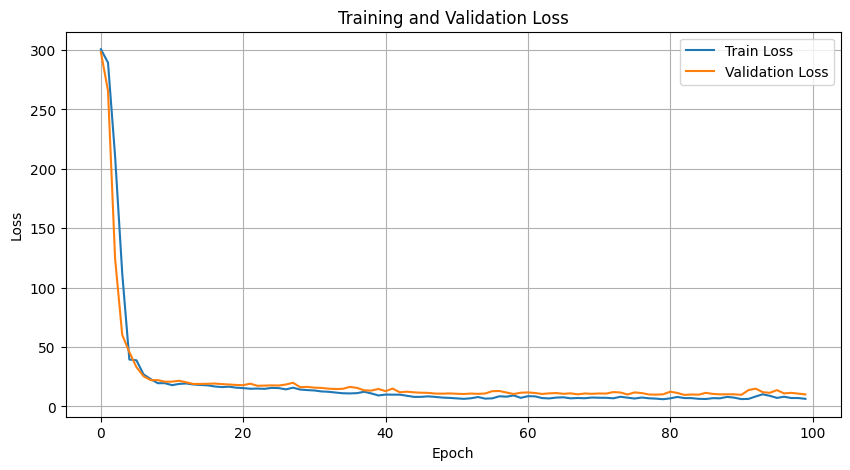

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

**Visualize Predictions**

In [ ]:
def visualize_prediction(subject_id, img_idx, model, root_dir):
    model.eval()
    subject_str = f"S_{subject_id}"
    img_dir = os.path.join(root_dir, 'openEDS', 'openEDS', subject_str)
    bbox_file = os.path.join(root_dir, 'bbox', 'bbox', f"{subject_str}.txt")

    img0 = Image.open(os.path.join(img_dir, f"{img_idx}.png")).convert('L')
    img1 = Image.open(os.path.join(img_dir, f"{img_idx+1}.png")).convert('L')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    img0_t = transform(img0)
    img1_t = transform(img1)
    diff = img1_t - img0_t
    input_tensor = torch.cat((img1_t, diff), dim=0).unsqueeze(0).to(device)

    with open(bbox_file, 'r') as f:
        bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]

    gt_box = bboxes[img_idx+1]
    pred_box = model(input_tensor).squeeze(0).detach().cpu().numpy()

    # Scale predicted box to original resolution (400x640)
    scale_x = 640 / 64
    scale_y = 400 / 64
    pred_box[0] *= scale_x
    pred_box[1] *= scale_x
    pred_box[2] *= scale_y
    pred_box[3] *= scale_y

    img = np.array(img1)
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')

    # Ground truth box (solid)
    gt_xmin, gt_xmax, gt_ymin, gt_ymax = gt_box
    plt.plot([gt_xmin, gt_xmax, gt_xmax, gt_xmin, gt_xmin],
             [gt_ymin, gt_ymin, gt_ymax, gt_ymax, gt_ymin], 'g-', label='Ground Truth')

    # Predicted box (dashed)
    pr_xmin, pr_xmax, pr_ymin, pr_ymax = pred_box
    plt.plot([pr_xmin, pr_xmax, pr_xmax, pr_xmin, pr_xmin],
             [pr_ymin, pr_ymin, pr_ymax, pr_ymax, pr_ymin], 'r--', label='Prediction')

    plt.legend()
    plt.title(f"Subject {subject_id}, Frame {img_idx+1}")
    plt.grid(True)
    plt.show()

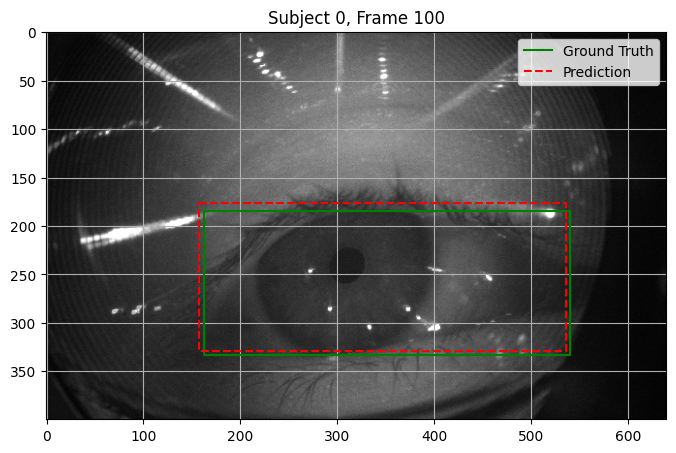

In [43]:
visualize_prediction(
    subject_id=0,
    img_idx=99,
    model=model,
    root_dir='/Users/omaraguilarjr/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/openEDS2019'
)

**Video for One Subject**

In [ ]:
def create_prediction_video(subject_id, model, root_dir, output_path='prediction_video.mp4', fps=10):
    model.eval()
    subject_str = f"S_{subject_id}"
    img_dir = os.path.join(root_dir, 'openEDS', 'openEDS', subject_str)
    bbox_file = os.path.join(root_dir, 'bbox', 'bbox', f"{subject_str}.txt")

    with open(bbox_file, 'r') as f:
        bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    fig, ax = plt.subplots()
    frames = []

    for idx in range(len(bboxes) - 1):
        img0 = Image.open(os.path.join(img_dir, f"{idx}.png")).convert('L')
        img1 = Image.open(os.path.join(img_dir, f"{idx+1}.png")).convert('L')
        img1_np = np.array(img1)

        img0_t = transform(img0)
        img1_t = transform(img1)
        diff = img1_t - img0_t
        input_tensor = torch.cat((img1_t, diff), dim=0).unsqueeze(0).to(device)
        pred_box = model(input_tensor).squeeze(0).detach().cpu().numpy()

        gt_box = bboxes[idx + 1]

        ax.clear()
        ax.imshow(img1_np, cmap='gray')

        gt_xmin, gt_xmax, gt_ymin, gt_ymax = gt_box
        ax.plot([gt_xmin, gt_xmax, gt_xmax, gt_xmin, gt_xmin],
                [gt_ymin, gt_ymin, gt_ymax, gt_ymax, gt_ymin], 'g-', label='Ground Truth')

        pr_xmin, pr_xmax, pr_ymin, pr_ymax = pred_box
        ax.plot([pr_xmin, pr_xmax, pr_xmax, pr_xmin, pr_xmin],
                [pr_ymin, pr_ymin, pr_ymax, pr_ymax, pr_ymin], 'r--', label='Prediction')

        ax.set_title(f'Subject {subject_id} - Frame {idx+1}')
        ax.axis('off')
        ax.legend()

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    import imageio
    imageio.mimsave(output_path, frames, fps=fps)
    plt.close(fig)

In [ ]:
create_prediction_video(
    subject_id=0,
    model=model,
    root_dir='/Users/omaraguilarjr/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/openEDS2019',
    output_path='subject_0_predictions.mp4',  # You can change the filename
    fps=10  # You can increase or decrease speed
)